In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.constants as const
import matplotlib as mpl
import os
home = os.path.expanduser('~')

# Read the results of TSC model

In [16]:
# Constant Setup
#
AU        = 1.49598e13     # Astronomical Unit       [cm]
pc        = 3.08572e18     # Parsec                  [cm]
MS        = 1.98892e33     # Solar mass              [g]
LS        = 3.8525e33      # Solar luminosity        [erg/s]
RS        = 6.96e10        # Solar radius            [cm]
G         = 6.67259e-8     # Gravitational constant  [cm3/g/s^2]
yr        = 60*60*24*365   # Years in seconds
PI        = np.pi          # PI constant
sigma     = const.sigma_sb.cgs.value  # Stefan-Boltzmann constant 
mh        = const.m_p.cgs.value + const.m_e.cgs.value

# Variable setup
#
# parameter from cycle "controlled", model 85
rstar     = 3 * RS
tstar     = 6584.0
R_env_max = 4.125300e+04 * AU
R_env_min = 0.118 *AU             # the inner radius is fixed, 0.100364     * AU 
R_cen     = 7.050696e-01 * AU
R_inf     = 1.285910e+03 * AU
theta_cav = 20.0
M_env_dot = 2.896073e-05 * MS/yr
mstar     = 3.533209e-01 * MS
rin       = rstar
rout      = R_env_max
rout_mike = 9.756000e+03 * AU
rcen      = R_cen

# Grid Parameters
nx        = 100L
ny        = 400L
nz        = 50L


# Make the Coordinates
#
ri           = rin * (rout/rin)**(np.arange(nx+1).astype(dtype='float')/float(nx))
ri           = np.hstack((0.0, ri))
thetai       = PI*np.arange(ny+1).astype(dtype='float')/float(ny)
phii         = PI*2.0*np.arange(nz+1).astype(dtype='float')/float(nz)

# 
ri_mike      = rin * (rout_mike/rin)**(np.arange(nx+1).astype(dtype='float')/float(nx))
ri_mike           = np.hstack((0.0, ri_mike))

# Keep the constant cell size in r-direction
#

ri_cellsize = ri[1:-1]-ri[0:-2]
ind = np.where(ri_cellsize/AU > 100.0)[0][0]       # The largest cell size is 100 AU
ri = np.hstack((ri[0:ind],ri[ind]+np.arange(np.ceil((rout-ri[ind])/100/AU))*100*AU))
nx = len(ri)-1

# the coordinates used for Mike's original code -- only do this for comparison
ri_mike_cellsize = ri_mike[1:-1]-ri_mike[0:-2]
ind_mike = np.where(ri_mike_cellsize/AU > 100.0)[0][0]       # The largest cell size is 100 AU
ri_mike = np.hstack((ri_mike[0:ind_mike],ri_mike[ind_mike]+np.arange(np.ceil((rout_mike-ri_mike[ind_mike])/100/AU))*100*AU))
nx_mike = len(ri_mike)-1 
rc_mike = 0.5*( ri_mike[0:nx_mike]     + ri_mike[1:nx_mike+1] )

# Assign the coordinates of the center of cell as its coordinates.
#
rc           = 0.5*( ri[0:nx]     + ri[1:nx+1] )
thetac       = 0.5*( thetai[0:ny] + thetai[1:ny+1] )
phic         = 0.5*( phii[0:nz]   + phii[1:nz+1] )

# rhoenv_tsc = np.genfromtxt('rhoenv.dat').T
rhoenv_tsc = np.genfromtxt('/Users/yaolun/test/rhoenv_1.dat').T
# velenv_tsc = np.genfromtxt('/Users/yaolun/test/velenv.dat').T
rhoenv_tsc_mike = np.genfromtxt('rhoenv_mike.dat').T

(479, 400) (479,) (400,) (50,)
79
1286.3166752 1285.91


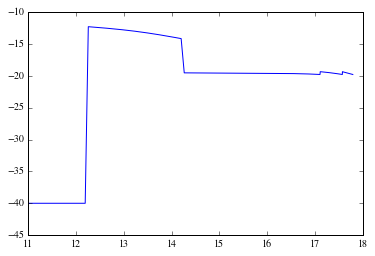

In [17]:
print np.shape(rhoenv_tsc), np.shape(rc), np.shape(thetac), np.shape(phic)
print np.where(rc >= R_inf)[0][0]
print rc[79]/AU, R_inf/AU
plt.plot(np.log10(rc), np.log10(rhoenv_tsc[:,0]))

### extrapolation at radius greater than infall radius

In [13]:
def poly(x, y, x0, deg=2):
    import numpy as np
    p = np.polyfit(x, y, deg)
    y0 = 0
    for i in range(0, len(p)):
        y0 = y0 + p[i]*x0**(len(p)-i-1)
    return y0

rho_env_tsc2d = np.empty((nx,ny)) 
if max(ri) > R_inf:
    ind_infall = np.where(rc <= R_inf)[0][-1]
    for i in range(0, len(rc)):
        if i <= ind_infall:
            rho_env_tsc2d[i,:] = rhoenv_tsc[i,:]
        else:
            rho_env_tsc2d[i,:] =  10**(np.log10(rhoenv_tsc[ind_infall,:]) - 2*(np.log10(rc[i]/rc[ind_infall])))
else:
    rho_env_tsc2d = rhoenv_tsc
# map it to 3-D grid
rho_env = np.empty((nx,ny,nz))
for i in range(0, nz):
    rho_env[:,:,i] = rho_env_tsc2d

# Calculate the infall-only model using Hyperion bulid-in function

In [14]:
import hyperion as hp
from hyperion.model import Model
from hyperion.model import AnalyticalYSOModel

m = AnalyticalYSOModel()

# Define the luminsoity source
source = m.add_spherical_source()
source.luminosity = (4*PI*rstar**2)*sigma*(tstar**4)  # [ergs/s]
source.radius = rstar  # [cm]
source.temperature = tstar  # [K]
source.position = (0., 0., 0.)
source.mass = mstar
print 'L_center =  % 5.2f L_sun' % ((4*PI*rstar**2)*sigma*(tstar**4)/LS)

# Envelope structure
#
envelope = m.add_ulrich_envelope()
envelope.mdot = M_env_dot    # Infall rate
envelope.rmin = rin          # Inner radius
envelope.rc   = R_cen         # Centrifugal radius
envelope.rmax = R_env_max    # Outer radius
envelope.star = source

grid = hp.grid.SphericalPolarGrid(ri, thetai, phii)

rho_ulrich = envelope.density(grid).T
rho_ulrich2d = np.sum(rho_ulrich**2,axis=2)/np.sum(rho_ulrich,axis=2)

/Users/yaolun/anaconda/lib/python2.7/site-packages/hyperion/densities/ulrich_envelope.py:34: RuntimeWarning: invalid value encountered in power
  s = dr ** (1. / 3.)
/Users/yaolun/anaconda/lib/python2.7/site-packages/hyperion/densities/ulrich_envelope.py:39: RuntimeWarning: invalid value encountered in power
  t = dr ** (1. / 3.)


L_center =   10.93 L_sun


/Users/yaolun/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide


# Calculate the infall model only

In [59]:
import numpy as np
import astropy.constants as const
import scipy as sci
import matplotlib.pyplot as plt
import matplotlib as mat
import os
from matplotlib.colors import LogNorm
from scipy.optimize import fsolve
from scipy.optimize import newton
from scipy.integrate import nquad
from envelope_func import func

# Grids and Density
# Calculation inherited from the script used for RADMC-3D

# Make the dust density model
# Make the density profile of the envelope
#
print 'Calculating the dust density profile...'
if theta_cav != 0:
    c = R_env_max**(-0.5)*np.sqrt(1/np.sin(np.radians(theta_cav))**3-1/np.sin(np.radians(theta_cav)))
else:
    c = 0
    print 'No cavity is applied'
rho_env  = np.zeros([len(rc),len(thetac),len(phic)])
# rho_disk = np.zeros([len(rc),len(thetac),len(phic)])
# rho      = np.zeros([len(rc),len(thetac),len(phic)])
def f(w,z,beta,rstar,h100):
    f = 2*PI*w*(1-np.sqrt(rstar/w))*(rstar/w)**(beta+1)*np.exp(-0.5*(z/(w**beta*h100/100**beta))**2)
    return f
# rho_0 = M_disk/(nquad(f,[[R_disk_min,R_disk_max],[-R_env_max,R_env_max]], args=(beta,rstar,h100)))[0]
i = 0
j = 0
if 'rho_cav_center' in locals() == False:
    rho_cav_center = 5.27e-18 # 1.6e-17  # 5.27e-18
    print 'Use 5.27e-18 as the default value for cavity center'
if 'rho_cav_edge' in locals() == False:
    rho_cav_edge = 40*AU
    print 'Use 40 AU as the default value for size of the inner region'
discont = 1
for ir in range(0,len(rc)):
    for itheta in range(0,len(thetac)):
        for iphi in range(0,len(phic)):
            if rc[ir] > R_env_min:
                # Envelope profile
                w = abs(rc[ir]*np.cos(thetac[itheta]))
                z = rc[ir]*np.sin(thetac[itheta])
                z_cav = c*abs(w)**1.5
                if z_cav == 0:
                    z_cav = R_env_max
                if abs(z) > abs(z_cav):
                    # rho_env[ir,itheta,iphi] = rho_cav
                    # Modification for using density gradient in the cavity
                    if rc[ir] <= rho_cav_edge:
                        rho_env[ir,itheta,iphi] = rho_cav_center#*((rc[ir]/AU)**2)
                    else:
                        rho_env[ir,itheta,iphi] = rho_cav_center*discont*(rho_cav_edge/rc[ir])**2
                    i += 1
                else:
                    j += 1
                    mu = abs(np.cos(thetac[itheta]))
#                     mu_o = np.abs(fsolve(func,[0.5,0.5,0.5],args=(rc[ir],rcen,mu))[0])
                    # Implement new root finding algorithm
                    roots = np.roots(np.array([1.0, 0.0, rc[ir]/rcen-1.0, -mu*rc[ir]/rcen]))
                    if len(roots[roots.imag == 0]) == 1:
                        if (abs(roots[roots.imag == 0]) - 1.0) <= 0.0:
                            mu_o_dum = roots[roots.imag == 0]
                        else:
                            mu_o_dum = -0.5
                            print 'Problem with cubic solving, cos(theta) = ', mu_o_dum
                            print 'parameters are ', np.array([1.0, 0.0, rc[ir]/rcen-1.0, -mu*rc[ir]/rcen])
                    else:
                        mu_o_dum = -0.5
                        for imu in range(0, len(roots)):
                            if roots[imu]*mu >= 0.0:
                                if (abs((abs(roots[imu]) - 1.0)) <= 1e-5):
                                    mu_o_dum = 1.0 * np.sign(mu)
                                else:
                                    mu_o_dum = roots[imu]
                        if mu_o_dum == -0.5:
                            print 'Problem with cubic solving, roots are: ', roots
                    mu_o = mu_o_dum.real
                    rho_env[ir,itheta,iphi] = M_env_dot/(4*PI*(G*mstar*rcen**3)**0.5)*(rc[ir]/rcen)**(-3./2)*(1+mu/mu_o)**(-0.5)*(mu/mu_o+2*mu_o**2*rcen/rc[ir])**(-1)
                # Disk profile
#                 if ((w >= R_disk_min) and (w <= R_disk_max)) == True:
#                     h = ((w/(100*AU))**beta)*h100
#                     rho_disk[ir,itheta,iphi] = rho_0*(1-np.sqrt(rstar/w))*(rstar/w)**(beta+1)*np.exp(-0.5*(z/h)**2)
                # Combine envelope and disk
#                 rho[ir,itheta,iphi] = rho_disk[ir,itheta,iphi] + rho_env[ir,itheta,iphi]
#             else:
#                 rho[ir,itheta,iphi] = 1e-30
rhoenv_infall  = rho_env  + 1e-40
# rho_disk = rho_disk + 1e-40
# rho      = rho      + 1e-40

Calculating the dust density profile...
No cavity is applied


## Streamline relation at different angle

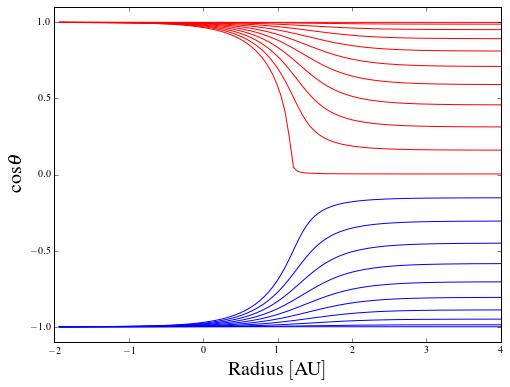

In [7]:
from scipy.optimize import fsolve
from scipy.optimize import newton
from envelope_func import func

def fprime(x, r, rcen, mu):
    return 3*float(x)**2 + float(r)/float(rcen)-1
plot_grid = [0,19,39,59,79,99,119,139,159,179,199,219,239,259,279,299,319,339,359,379,399]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for i in plot_grid:
    mu = np.cos(thetac[i])
#     print thetac[i]
    mu_o_newton = np.empty_like(rc)
    mu_o = np.empty_like(rc)
    mu_oo = np.empty_like(rc)
    for ir in range(0, len(rc)):
#         mu_o_newton[ir] = newton(func, 0.5, fprime=fprime, args=(rc[ir],rcen,mu))
#         mu_o[ir] = np.abs(fsolve(func,[0.5,0.5,0.5], args=(rc[ir],rcen,mu))[0])
        roots = np.roots(np.array([1.0, 0.0, rc[ir]/rcen-1.0, -mu*rc[ir]/rcen]))
        if len(roots[roots.imag == 0]) == 1:
            if (abs(roots[roots.imag == 0]) - 1.0) <= 0.0:
                mu_o_dum = roots[roots.imag == 0]
            else:
                mu_o_dum = -0.5
                print 'Problem with cubic solving, cos(theta) = ', mu_o_dum
                print 'parameters are ', np.array([1.0, 0.0, rc[ir]/rcen-1.0, -mu*rc[ir]/rcen])
        else:
            mu_o_dum = -0.5
            for imu in range(0, len(roots)):
#                 print roots[roots[imu]*mu >= 0.0]
                if roots[imu]*mu >= 0.0:
                    if (abs((abs(roots[imu]) - 1.0)) <= 1e-5):
                        mu_o_dum = 1.0 * np.sign(mu)
                    else:
                        mu_o_dum = roots[imu]
            if mu_o_dum == -0.5:
                print 'Problem with cubic solving, roots are: ', roots
#         if (rc[ir]/AU > 10) and (rc[ir]/AU < 120) and i == 199:
#             print roots
#             print mu_o_dum.real
        mu_oo[ir] = mu_o_dum.real
#     scipy_sol, = ax.plot(np.log10(rc/AU), mu_o,'b')
#     plt.plot(np.log10(rc/AU), mu_o_newton,'g')
    if mu >= 0:
        add_sol, = ax.plot(np.log10(rc/AU), mu_oo,'r')
    else:
        add_sol, = ax.plot(np.log10(rc/AU), mu_oo,'b')
ax.set_ylim([-1.1,1.1])
ax.set_xlabel(r'$\mathrm{Radius~[AU]}$',fontsize=20)
ax.set_ylabel(r'$\mathrm{cos\theta}$',fontsize=20)
# print mu_o_newton**3 + mu_o_newton*(r/rcen-1) - mu*r/rcen
# rho = M_env_dot/(4*PI*(G*mstar*rcen**3)**0.5)*(r/rcen)**(-3./2)*(1+mu/mu_o_newton)**(-0.5)*(mu/mu_o_newton+2*mu_o_newton**2*rcen/r)**(-1)


## TSC model - Mike's

[None, None, None, None, None, None, None, None, None, None]

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:992: RuntimeWarning: invalid value encountered in less_equal
  mask = (resdat <= 0)
/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:584: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


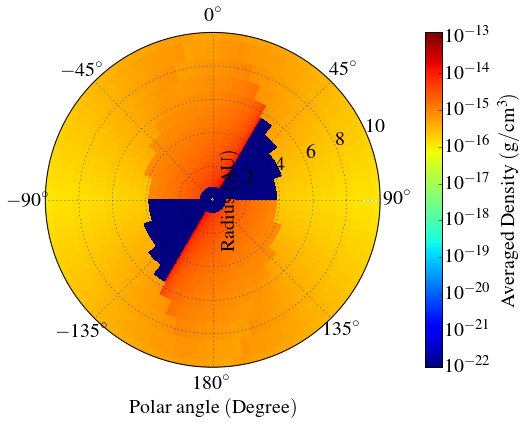

In [8]:
fig = plt.figure(figsize=(8,6))
ax_env  = fig.add_subplot(111,projection='polar')

zmin = 1e-22
cmap = 'jet'
img_env = ax_env.pcolormesh(thetai[0:-1],rc_mike/AU,rhoenv_tsc_mike,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rhoenv_tsc_mike)))
ax_env.pcolormesh(thetai[0:-1]-PI,rc_mike/AU,rhoenv_tsc_mike,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rhoenv_tsc_mike)))

ax_env.set_xlabel(r'$\mathrm{Polar~angle~(Degree)}$',fontsize=20)
ax_env.set_ylabel(r'$\mathrm{Radius~(AU)}$',fontsize=20)
ax_env.tick_params(labelsize=20)
ax_env.set_ylim([0,10])
ax_env.set_xticklabels([r'$\mathrm{90^{\circ}}$',r'$\mathrm{45^{\circ}}$',r'$\mathrm{0^{\circ}}$',r'$\mathrm{-45^{\circ}}$',\
                        r'$\mathrm{-90^{\circ}}$',r'$\mathrm{-135^{\circ}}$',r'$\mathrm{180^{\circ}}$',r'$\mathrm{135^{\circ}}$'])
ax_env.grid(True)
cb = fig.colorbar(img_env, pad=0.1)
cb.ax.set_ylabel(r'$\mathrm{Averaged~Density~(g/cm^{3})}$',fontsize=20)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=20)

## TSC model - revised

[None, None, None, None, None, None, None, None, None, None]

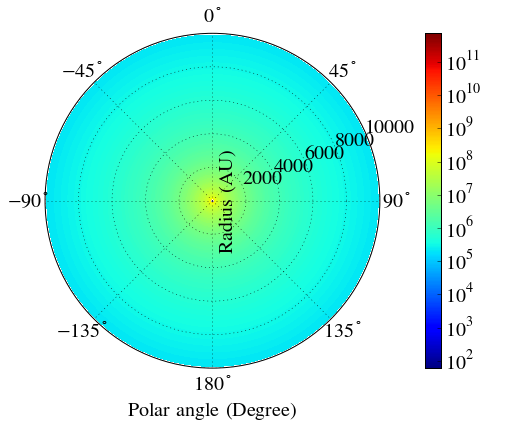

In [17]:
fig = plt.figure(figsize=(8,6))
ax_env  = fig.add_subplot(111,projection='polar')

rhoenv_tsc_exp = np.hstack((rho_env_tsc2d, rho_env_tsc2d, rho_env_tsc2d[:,0:1]))
thetac_exp = np.hstack((thetac-PI/2, thetac+PI/2, thetac[0]-PI/2))

zmin = 1e-22/mh
cmap = 'jet'
img_env = ax_env.pcolormesh(thetac_exp,rc/AU,rhoenv_tsc_exp/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rhoenv_tsc_exp/mh)))
# img_env = ax_env.pcolormesh(thetac_exp,rc/AU,rhoenv_tsc_exp/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(1e12)))


ax_env.set_xlabel(r'$\rm{Polar\,angle\,(Degree)}$',fontsize=20)
ax_env.set_ylabel(r'$\rm{Radius\,(AU)}$',fontsize=20)
ax_env.tick_params(labelsize=20)
# ax_env.set_yticks(np.arange(0,R_env_max/AU,R_env_max/AU/5))
ax_env.set_ylim([0,10000])
ax_env.set_xticklabels([r'$\rm{90^{\circ}}$',r'$\rm{45^{\circ}}$',r'$\rm{0^{\circ}}$',r'$\rm{-45^{\circ}}$',\
                        r'$\rm{-90^{\circ}}$',r'$\rm{-135^{\circ}}$',r'$\rm{180^{\circ}}$',r'$\rm{135^{\circ}}$'])
ax_env.grid(True)
cb = fig.colorbar(img_env, pad=0.1)
cb.ax.set_ylabel(r'$\rm{Averaged~Density\,(cm^{-3})}$',fontsize=20)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=20)

##TSC model - velocity

In [ ]:
fig = plt.figure(figsize=(8,6))
ax_env = fig.add_subplot(111,projection='polar')

velenv_tsc_exp = np.hstack((velenv_tsc,velenv_tsc,velenv_tsc[:,0:1]))
thetac_exp = np.hstack((thetac-PI/2, thetac+PI/2, thetac[0]-PI/2))

zmin = 1e-22/mh
cmap = 'jet'
img_env = ax_env.pcolormesh(thetac_exp,rc/AU,velenv_tsc_exp/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rhoenv_tsc_exp/mh)))
# img_env = ax_env.pcolormesh(thetac_exp,rc/AU,rhoenv_tsc_exp/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(1e12)))


ax_env.set_xlabel(r'$\rm{Polar\,angle\,(Degree)}$',fontsize=20)
ax_env.set_ylabel(r'$\rm{Radius\,(AU)}$',fontsize=20)
ax_env.tick_params(labelsize=20)
# ax_env.set_yticks(np.arange(0,R_env_max/AU,R_env_max/AU/5))
ax_env.set_ylim([0,20000])
ax_env.set_xticklabels([r'$\rm{90^{\circ}}$',r'$\rm{45^{\circ}}$',r'$\rm{0^{\circ}}$',r'$\rm{-45^{\circ}}$',\
                        r'$\rm{-90^{\circ}}$',r'$\rm{-135^{\circ}}$',r'$\rm{180^{\circ}}$',r'$\rm{135^{\circ}}$'])
ax_env.grid(True)
cb = fig.colorbar(img_env, pad=0.1)
cb.ax.set_ylabel(r'$\rm{Averaged~Density\,(cm^{-3})}$',fontsize=20)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=20)

## Infall-only solution

[None, None, None, None, None, None, None, None, None]

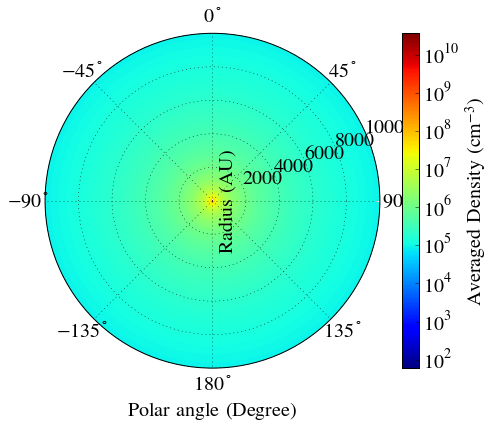

In [19]:
# take the weighted average
rhoenv_infall_avg = np.sum(rhoenv_infall**2,axis=2)/np.sum(rhoenv_infall,axis=2)

fig = plt.figure(figsize=(8,6))
ax_env  = fig.add_subplot(111,projection='polar')

zmin = 1e-22/mh
cmap = 'jet'
img_env = ax_env.pcolormesh(thetai[0:-1],rc/AU,rhoenv_infall_avg/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rhoenv_infall_avg/mh)))
ax_env.pcolormesh(thetai[0:-1]-PI,rc/AU,rhoenv_infall_avg/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rhoenv_infall_avg/mh)))

ax_env.set_xlabel(r'$\rm{Polar\,angle\,(Degree)}$',fontsize=20)
ax_env.set_ylabel(r'$\rm{Radius\,(AU)}$',fontsize=20)
ax_env.tick_params(labelsize=20)
# ax_env.set_yticks(np.arange(0,R_env_max/AU,R_env_max/AU/5))
ax_env.set_xticklabels([r'$\rm{90^{\circ}}$',r'$\rm{45^{\circ}}$',r'$\rm{0^{\circ}}$',r'$\rm{-45^{\circ}}$',\
                        r'$\rm{-90^{\circ}}$',r'$\rm{-135^{\circ}}$',r'$\rm{180^{\circ}}$',r'$\rm{135^{\circ}}$'])
ax_env.set_ylim([0,10000])
ax_env.grid(True)
cb = fig.colorbar(img_env )
cb.ax.set_ylabel(r'$\rm{Averaged\,Density\,(cm^{-3})}$',fontsize=20)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=20)

## Infall-only solution from hyperion (Ulrich)

[None, None, None, None, None, None, None, None, None, None, None]

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:992: RuntimeWarning: invalid value encountered in less_equal
  mask = (resdat <= 0)
/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:584: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


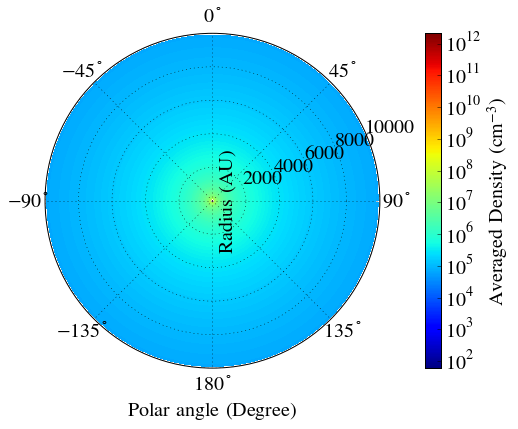

In [18]:
fig = plt.figure(figsize=(8,6))
ax_env  = fig.add_subplot(111,projection='polar')

zmin = 1e-22/mh
cmap = 'jet'
img_env = ax_env.pcolormesh(thetai[0:-1],rc/AU,rho_ulrich2d/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rho_ulrich2d/mh)))
ax_env.pcolormesh(thetai[0:-1]-PI,rc/AU,rho_ulrich2d/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rho_ulrich2d/mh)))

ax_env.set_xlabel(r'$\rm{Polar\,angle\,(Degree)}$',fontsize=20)
ax_env.set_ylabel(r'$\rm{Radius\,(AU)}$',fontsize=20)
ax_env.tick_params(labelsize=20)
# ax_env.set_yticks(np.arange(0,R_env_max/AU,R_env_max/AU/5))
ax_env.set_xticklabels([r'$\rm{90^{\circ}}$',r'$\rm{45^{\circ}}$',r'$\rm{0^{\circ}}$',r'$\rm{-45^{\circ}}$',\
                        r'$\rm{-90^{\circ}}$',r'$\rm{-135^{\circ}}$',r'$\rm{180^{\circ}}$',r'$\rm{135^{\circ}}$'])
ax_env.set_ylim([0,10000])
ax_env.grid(True)
cb = fig.colorbar(img_env, pad=0.1)
cb.ax.set_ylabel(r'$\rm{Averaged\,Density\,(cm^{-3})}$',fontsize=20)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=20)

## Inspecting the old (wrong) model

[None, None, None, None, None, None, None, None, None, None]

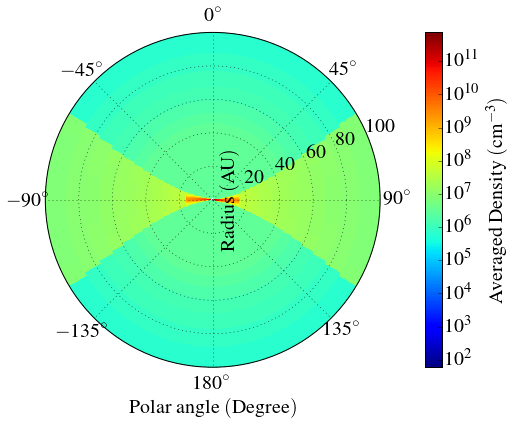

In [12]:
import hyperion as hp
from hyperion.model import *

m = ModelOutput('/Users/yaolun/bhr71/hyperion/test_phase/old_setup.rtout')
grid = m.get_quantities()
rho_wrong = grid['density'][0].array.T
rc_w     = 0.5*(grid.r_wall[0:-1]+grid.r_wall[1:])
thetac_w = 0.5*(grid.t_wall[0:-1]+grid.t_wall[1:])
phic_w   = 0.5*(grid.p_wall[0:-1]+grid.p_wall[1:])

rho_wrong2d = np.sum(rho_wrong**2,axis=2)/np.sum(rho_wrong,axis=2)
# rho_wrong2d = rho_wrong[:,:,0]

fig = plt.figure(figsize=(8,6))
ax_env  = fig.add_subplot(111,projection='polar')

zmin = 1e-22/mh
cmap = 'jet'
img_env = ax_env.pcolormesh(thetac_w,rc_w/AU,rho_wrong2d/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rho_wrong2d/mh)))
ax_env.pcolormesh(thetac_w-PI,rc_w/AU,rho_wrong2d/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rho_wrong2d/mh)))

ax_env.set_xlabel(r'$\mathrm{Polar~angle~(Degree)}$',fontsize=20)
ax_env.set_ylabel(r'$\mathrm{Radius~(AU)}$',fontsize=20)
ax_env.tick_params(labelsize=20)
# ax_env.set_yticks(np.arange(0,R_env_max/AU,R_env_max/AU/5))
ax_env.set_xticklabels([r'$\mathrm{90^{\circ}}$',r'$\mathrm{45^{\circ}}$',r'$\mathrm{0^{\circ}}$',r'$\mathrm{-45^{\circ}}$',\
                        r'$\mathrm{-90^{\circ}}$',r'$\mathrm{-135^{\circ}}$',r'$\mathrm{180^{\circ}}$',r'$\mathrm{135^{\circ}}$'])
ax_env.set_ylim([0,100])
ax_env.grid(True)
cb = fig.colorbar(img_env, pad=0.1)
cb.ax.set_ylabel(r'$\mathrm{Averaged~Density~(cm^{-3})}$',fontsize=20)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=20)

[None, None, None, None, None, None, None, None, None, None]

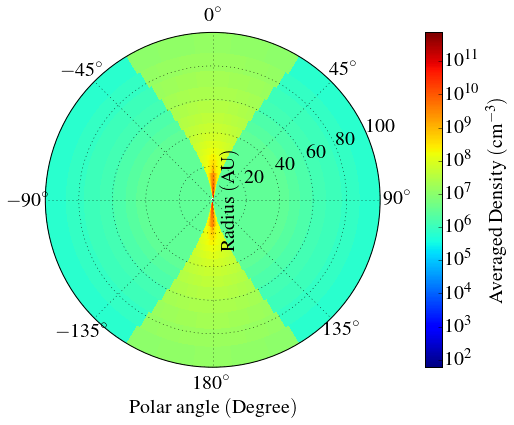

In [13]:
m2 = ModelOutput('/Users/yaolun/bhr71/hyperion/test_phase/old_setup2.rtout')
grid2 = m2.get_quantities()
rho_wrong2 = grid2['density'][0].array.T

rho_wrong2d2 = np.sum(rho_wrong2**2,axis=2)/np.sum(rho_wrong2,axis=2)

fig = plt.figure(figsize=(8,6))
ax_env  = fig.add_subplot(111,projection='polar')

zmin = 1e-22/mh
cmap = 'jet'
img_env = ax_env.pcolormesh(thetac_w,rc_w/AU,rho_wrong2d2/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rho_wrong2d2/mh)))
ax_env.pcolormesh(thetac_w-PI,rc_w/AU,rho_wrong2d2/mh,cmap=cmap,norm=LogNorm(vmin=zmin,vmax=np.nanmax(rho_wrong2d2/mh)))

ax_env.set_xlabel(r'$\mathrm{Polar~angle~(Degree)}$',fontsize=20)
ax_env.set_ylabel(r'$\mathrm{Radius~(AU)}$',fontsize=20)
ax_env.tick_params(labelsize=20)
# ax_env.set_yticks(np.arange(0,R_env_max/AU,R_env_max/AU/5))
ax_env.set_xticklabels([r'$\mathrm{90^{\circ}}$',r'$\mathrm{45^{\circ}}$',r'$\mathrm{0^{\circ}}$',r'$\mathrm{-45^{\circ}}$',\
                        r'$\mathrm{-90^{\circ}}$',r'$\mathrm{-135^{\circ}}$',r'$\mathrm{180^{\circ}}$',r'$\mathrm{135^{\circ}}$'])
ax_env.set_ylim([0,100])
ax_env.grid(True)
cb = fig.colorbar(img_env, pad=0.1)
cb.ax.set_ylabel(r'$\mathrm{Averaged~Density~(cm^{-3})}$',fontsize=20)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=20)

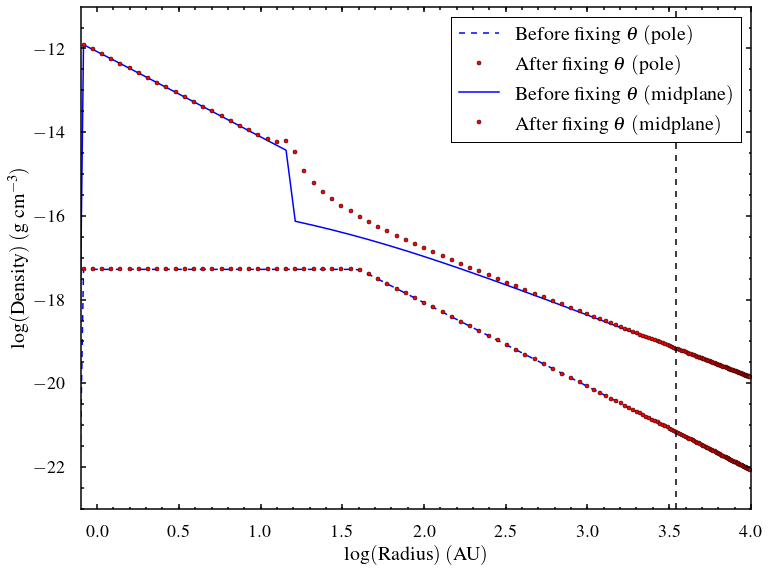

In [14]:
plot_r_inf = 3500
plot_rcen = 15

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)

plot_grid = [0,39,79,119,159,199]
# plot_grid = [0]
# print thetac[0]
# for i in plot_grid:
wrong_mid,  = ax.plot(np.log10(rc_w/AU), np.log10(rho_wrong2d[:,0]),'-',color='b',linewidth=1.5, markersize=3)
wrong2_mid, = ax.plot(np.log10(rc_w/AU), np.log10(rho_wrong2d2[:,199]),'o',color='r',linewidth=1.5, markersize=4)
wrong,  = ax.plot(np.log10(rc_w/AU), np.log10(rho_wrong2d[:,199]),'--',color='b',linewidth=1.5, markersize=3)
wrong2, = ax.plot(np.log10(rc_w/AU), np.log10(rho_wrong2d2[:,0]),'o',color='r',linewidth=1.5, markersize=4)

rinf = ax.axvline(np.log10(plot_r_inf), linestyle='--', color='k', linewidth=1.5)
# cen_r = ax.axvline(np.log10(plot_rcen), linestyle='--', color='r', linewidth=1.5)
# sisslope, = ax.plot(np.log10(rc/AU), -2*np.log10(rc/AU)+A-(-2)*np.log10(plot_r_inf), linestyle='--', color='Orange', linewidth=1.5)
# gt_rcen_slope, = ax.plot(np.log10(rc/AU), -1.5*np.log10(rc/AU)+B-(-1.5)*np.log10(plot_r_inf), linestyle='--', color='Orange', linewidth=1.5)
# lt_rcen_slope, = ax.plot(np.log10(rc/AU), -0.5*np.log10(rc/AU)+A-(-0.5)*np.log10(plot_r_inf), linestyle='--', color='Orange', linewidth=1.5)

lg = plt.legend([wrong, wrong2, wrong_mid, wrong2_mid],\
                [r'$\mathrm{Before~fixing~\theta~(pole)}$',r'$\mathrm{After~fixing~\theta~(pole)}$',r'$\mathrm{Before~fixing~\theta~(midplane)}$',r'$\mathrm{After~fixing~\theta~(midplane)}$'],\
                fontsize=20, numpoints=1)
ax.set_xlabel(r'$\mathrm{log(Radius)~(AU)}$',fontsize=20)
ax.set_ylabel(r'$\mathrm{log(Density)~(g~cm^{-3})}$',fontsize=20)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)
ax.set_ylim([-23,-11])
ax.set_xlim([np.log10(0.8),np.log10(10000)])

fig.savefig('image_problem.pdf',format='pdf',dpi=300,bbox_inches='tight')

0.00392699081699


ValueError: x and y must have same first dimension

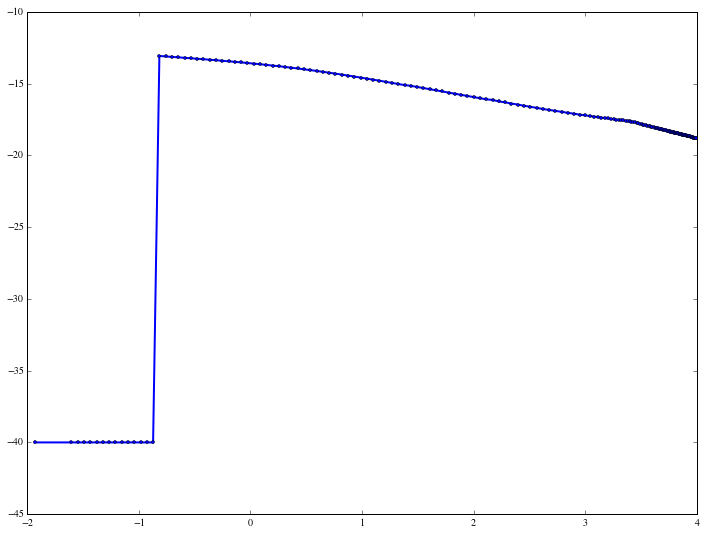

In [58]:
plot_r_inf = 3500
plot_rcen = 15
A = np.log10(rhoenv_tsc[abs(rc/AU - plot_r_inf) < 50 ,0])
B = np.log10(rhoenv_infall_avg[abs(rc/AU - plot_r_inf) < 50 ,0])

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)

plot_grid = [0,39,79,119,159,199]
# plot_grid = [0]
print thetac[0]
for i in plot_grid:
    tsc, = ax.plot(np.log10(rc/AU), np.log10(rho2d_avg[:,i]),'o-',color='b',linewidth=2, markersize=3)
    infall, = ax.plot(np.log10(rc/AU), np.log10(rhoenv_infall_avg[:,i]),'o-',color='g',linewidth=2, markersize=3)
#     ulrich, = ax.plot(np.log10(rc/AU), np.log10(rho_ulrich2d[:,i]),'o--',color='m',linewidth=2, markersize=3)
rinf = ax.axvline(np.log10(plot_r_inf), linestyle='--', color='r', linewidth=1.5)
cen_r = ax.axvline(np.log10(plot_rcen), linestyle='--', color='r', linewidth=1.5)
sisslope, = ax.plot(np.log10(rc/AU), -2*np.log10(rc/AU)+A-(-2)*np.log10(plot_r_inf), linestyle='--', color='Orange', linewidth=1.5)
gt_rcen_slope, = ax.plot(np.log10(rc/AU), -1.5*np.log10(rc/AU)+B-(-1.5)*np.log10(plot_r_inf), linestyle='--', color='Orange', linewidth=1.5)
lt_rcen_slope, = ax.plot(np.log10(rc/AU), -0.5*np.log10(rc/AU)+A-(-0.5)*np.log10(plot_r_inf), linestyle='--', color='Orange', linewidth=1.5)

# lg = plt.legend([tsc, infall, ulrich, rinf, cen_r, sisslope, gt_rcen_slope, lt_rcen_slope],\
#                 [r'$\mathrm{TSC~model}$',r'$\mathrm{Infall~solution~only}$',r'$\mathrm{Ulrich~(\textsc{hyperion})}$',r'$\mathrm{infall~radius}$',r'$\mathrm{centrifugal~radius}$',r'$\mathrm{r^{-2}}$',r'$\mathrm{r^{-1.5}}$',r'$\mathrm{r^{-0.5}}$'],\
#                 fontsize=20, numpoints=1)
ax.set_xlabel(r'$\rm{log(Radius)\,(AU)}$',fontsize=20)
ax.set_ylabel(r'$\rm{log(Density)\,(g\,cm^{-3})}$',fontsize=20)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)
ax.set_ylim([-20,-12])
ax.set_xlim([np.log10(0.8),np.log10(10000)])

# subplot shows the radial density profile along the midplane
ax_mid = plt.axes([0.2,0.2,0.2,0.2], frameon=True)
ax_mid.plot(np.log10(rc/AU), np.log10(rhoenv_tsc[:,199]),'o-',color='b',linewidth=1, markersize=2)
ax_mid.plot(np.log10(rc/AU), np.log10(rhoenv_infall_avg[:,199]),'o-',color='g',linewidth=1, markersize=2)
# ax_mid.plot(np.log10(rc/AU), np.log10(rho_ulrich2d[:,199]),'o--',color='m',linewidth=1, markersize=2)
ax_mid.set_ylim([-20,-12])
ax_mid.set_xlim([np.log10(0.8),np.log10(10000)])
# fig.savefig('model_comparison.pdf',format='pdf',dpi=300,bbox_inches='tight')

In [64]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.constants as const
import os
import scipy as sci
from scipy.optimize import fsolve
from scipy.optimize import newton
from scipy.integrate import nquad
from envelope_func import func
home = os.path.expanduser('~')

# read the TSC model
# Constant Setup
#
AU        = 1.49598e13     # Astronomical Unit       [cm]
pc        = 3.08572e18     # Parsec                  [cm]
MS        = 1.98892e33     # Solar mass              [g]
LS        = 3.8525e33      # Solar luminosity        [erg/s]
RS        = 6.96e10        # Solar radius            [cm]
G         = 6.67259e-8     # Gravitational constant  [cm3/g/s^2]
yr        = 60*60*24*365   # Years in seconds
PI        = np.pi          # PI constant
sigma     = const.sigma_sb.cgs.value  # Stefan-Boltzmann constant 
mh        = const.m_p.cgs.value + const.m_e.cgs.value

# Variable setup
#
# parameter from cycle 7, model 46
rstar     = 5 * RS
tstar     = 4700.0
R_env_max = 1.000000e+04 * AU
R_env_min = 0.14         * AU             # the inner radius is fixed, 0.100364     * AU 
R_cen     = 8.111320e-01 * AU
R_inf     = 2.082753e+03 * AU
R_disk_min= 0.100364     * AU 
R_disk_max= R_cen
theta_cav = 20.0
beta      = 1.093
h100      = 8.123        * AU
M_env_dot = 1.271306e-05 * MS/yr
M_disk    = 0.5 * MS
mstar     = 3.305397e-01 * MS
rin       = rstar
rout      = R_env_max
rout_mike = 9.756000e+03 * AU
rho_cav_center = 5e-19
rho_cav_edge = 40 * AU

# Grid Parameters
nx        = 100L
ny        = 400L
nz        = 50L

# Make the Coordinates
#
ri           = rin * (rout/rin)**(np.arange(nx+1).astype(dtype='float')/float(nx))
ri           = np.hstack((0.0, ri))
thetai       = PI*np.arange(ny+1).astype(dtype='float')/float(ny)
phii         = PI*2.0*np.arange(nz+1).astype(dtype='float')/float(nz)

# Keep the constant cell size in r-direction
#

ri_cellsize = ri[1:-1]-ri[0:-2]
ind = np.where(ri_cellsize/AU > 100.0)[0][0]       # The largest cell size is 100 AU
ri = np.hstack((ri[0:ind],ri[ind]+np.arange(np.ceil((rout-ri[ind])/100/AU))*100*AU))
nx = len(ri)-1

# Assign the coordinates of the center of cell as its coordinates.
#
rc           = 0.5*( ri[0:nx]     + ri[1:nx+1] )
thetac       = 0.5*( thetai[0:ny] + thetai[1:ny+1] )
phic         = 0.5*( phii[0:nz]   + phii[1:nz+1] )

rhoenv_tsc = np.genfromtxt('/Users/yaolun/test/rhoenv.dat').T

# extrapolation at the radius greater than infall radius

def poly(x, y, x0, deg=2):
    import numpy as np
    p = np.polyfit(x, y, deg)
    y0 = 0
    for i in range(0, len(p)):
        y0 = y0 + p[i]*x0**(len(p)-i-1)
    return y0

rho_env_tsc2d = np.empty((nx,ny)) 
if max(ri) > R_inf:
    ind_infall = np.where(rc <= R_inf)[0][-1]
    for i in range(0, len(rc)):
        if i <= ind_infall:
            rho_env_tsc2d[i,:] = rhoenv_tsc[i,:]
        else:
            rho_env_tsc2d[i,:] =  10**(np.log10(rhoenv_tsc[ind_infall,:]) - 2*(np.log10(rc[i]/rc[ind_infall])))
else:
    rho_env_tsc2d = rhoenv_tsc
# map it to 3-D grid
rho_env_tsc = np.empty((nx,ny,nz))
for i in range(0, nz):
    rho_env_tsc[:,:,i] = rho_env_tsc2d

# calculate the infall-only solution

import hyperion as hp
from hyperion.model import Model
from hyperion.model import AnalyticalYSOModel

m = AnalyticalYSOModel()

# Define the luminsoity source
source = m.add_spherical_source()
source.luminosity = (4*PI*rstar**2)*sigma*(tstar**4)  # [ergs/s]
source.radius = rstar  # [cm]
source.temperature = tstar  # [K]
source.position = (0., 0., 0.)
source.mass = mstar
print 'L_center =  % 5.2f L_sun' % ((4*PI*rstar**2)*sigma*(tstar**4)/LS)

# Envelope structure
#
envelope = m.add_ulrich_envelope()
envelope.mdot = M_env_dot    # Infall rate
envelope.rmin = rin          # Inner radius
envelope.rc   = R_cen         # Centrifugal radius
envelope.rmax = R_env_max    # Outer radius
envelope.star = source

grid = hp.grid.SphericalPolarGrid(ri, thetai, phii)

rho_env_ulrich = envelope.density(grid).T
rho_env_ulrich2d = np.sum(rho_env_ulrich**2,axis=2)/np.sum(rho_env_ulrich,axis=2)

# calculate the full density field

# Grids and Density
# Calculation inherited from the script used for RADMC-3D

# Make the dust density model
# Make the density profile of the envelope
#
print 'Calculating the dust density profile...'
if theta_cav != 0:
    c0 = (1e4*AU)**(-0.5)*np.sqrt(1/np.sin(np.radians(theta_cav))**3-1/np.sin(np.radians(theta_cav)))
else:
    c0 = 0
    print 'No cavity is applied'
rho_tsc  = np.zeros([len(rc),len(thetac),len(phic)])
rho_ulrich = np.zeros([len(rc),len(thetac),len(phic)])
rho_disk = np.zeros([len(rc), len(thetac), len(phic)])

# function for normalizing the disk mass
def f(w,z,beta,rstar,h100):
    f = 2*PI*w*(1-np.sqrt(rstar/w))*(rstar/w)**(beta+1)*np.exp(-0.5*(z/(w**beta*h100/100**beta))**2)
    return f
rho_0 = M_disk/(nquad(f,[[R_disk_min,R_disk_max],[-R_env_max,R_env_max]], args=(beta,rstar,h100)))[0]
print rho_0
#
total_mass_tsc = 0
total_mass_ulrich = 0
#
for ir in range(0,len(rc)):
    for itheta in range(0,len(thetac)):
        for iphi in range(0,len(phic)):
            if rc[ir] > R_env_min:
                # Envelope profile
                w = abs(rc[ir]*np.cos(np.pi/2 - thetac[itheta]))
                z = rc[ir]*np.sin(np.pi/2 - thetac[itheta])
                z_cav = c0*abs(w)**1.5
                if z_cav == 0:
                    z_cav = R_env_max
                # Cavity
                if abs(z) > abs(z_cav):
                    # Modification for using density gradient in the cavity
                    # option for using a power law profile without constant region
                    if rho_cav_edge == 0:
                        rho_cav_edge = R_env_min
                    # the rho_cav_center is the dust density calculated from mass loss rate
                    # gas-to-dust ratio of 100 is applied after the whole calculation, therefore need to time 100 now
                    if (rc[ir] <= rho_cav_edge) & (rc[ir] >= R_env_min):
                        rho_env_tsc[ir,itheta,iphi] = 100 * rho_cav_center#*((rc[ir]/AU)**2)
                        rho_env_ulrich[ir,itheta,iphi] = 100 * rho_cav_center
                    else:
                        rho_env_tsc[ir,itheta,iphi] = 100 * rho_cav_center*(rho_cav_edge/rc[ir])**2
                        rho_env_ulrich[ir,itheta,iphi] = 100 * rho_cav_center*(rho_cav_edge/rc[ir])**2
                    
                # manually calculate the infall-only solution
                else:
                    mu = abs(np.cos(thetac[itheta]))
                    # Implement new root finding algorithm
                    roots = np.roots(np.array([1.0, 0.0, rc[ir]/rcen-1.0, -mu*rc[ir]/R_cen]))
                    if len(roots[roots.imag == 0]) == 1:
                        if (abs(roots[roots.imag == 0]) - 1.0) <= 0.0:
                            mu_o_dum = roots[roots.imag == 0]
                        else:
                            mu_o_dum = -0.5
                            print 'Problem with cubic solving, cos(theta) = ', mu_o_dum
                            print 'parameters are ', np.array([1.0, 0.0, rc[ir]/R_cen-1.0, -mu*rc[ir]/R_cen])
                    else:
                        mu_o_dum = -0.5
                        for imu in range(0, len(roots)):
                            if roots[imu]*mu >= 0.0:
                                if (abs((abs(roots[imu]) - 1.0)) <= 1e-5):
                                    mu_o_dum = 1.0 * np.sign(mu)
                                else:
                                    mu_o_dum = roots[imu]
                        if mu_o_dum == -0.5:
                            print 'Problem with cubic solving, roots are: ', roots
                    mu_o = mu_o_dum.real
                    rho_env_ulrich[ir,itheta,iphi] = M_env_dot/(4*PI*(G*mstar*R_cen**3)**0.5)*(rc[ir]/R_cen)**(-3./2)*(1+mu/mu_o)**(-0.5)*(mu/mu_o+2*mu_o**2*R_cen/rc[ir])**(-1)

                # Disk profile
#                 if ((w >= R_disk_min) and (w <= R_disk_max)) == True:
#                     h = ((w/(100*AU))**beta)*h100
#                     rho_disk[ir,itheta,iphi] = rho_0*(1-np.sqrt(rstar/w))*(rstar/w)**(beta+1)*np.exp(-0.5*(z/h)**2)
                
                # Combine envelope and disk
                rho_tsc[ir,itheta,iphi] = rho_disk[ir,itheta,iphi] + rho_env_tsc[ir,itheta,iphi]
                rho_ulrich[ir,itheta,iphi] = rho_disk[ir,itheta,iphi] + rho_env_ulrich[ir,itheta,iphi]# rho_env_ulrich[ir,itheta,iphi]                    
            else:
                rho_tsc[ir,itheta,iphi] = 1e-40
                rho_ulrich[ir,itheta,iphi] = 1e-40
            # add the dust mass into the total count
            cell_mass_tsc = rho_tsc[ir, itheta, iphi] * (1/3.)*(ri[ir+1]**3 - ri[ir]**3) * (phii[iphi+1]-phii[iphi]) * -(np.cos(thetai[itheta+1])-np.cos(thetai[itheta]))
            total_mass_tsc = total_mass_tsc + cell_mass_tsc

            cell_mass_ulrich = rho_ulrich[ir, itheta, iphi] * (1/3.)*(ri[ir+1]**3 - ri[ir]**3) * (phii[iphi+1]-phii[iphi]) * -(np.cos(thetai[itheta+1])-np.cos(thetai[itheta]))
            total_mass_ulrich = total_mass_ulrich + cell_mass_ulrich

L_center =   10.93 L_sun
Calculating the dust density profile...
3.78424288241e-09


/Users/yaolun/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:133: RuntimeWarning: invalid value encountered in divide


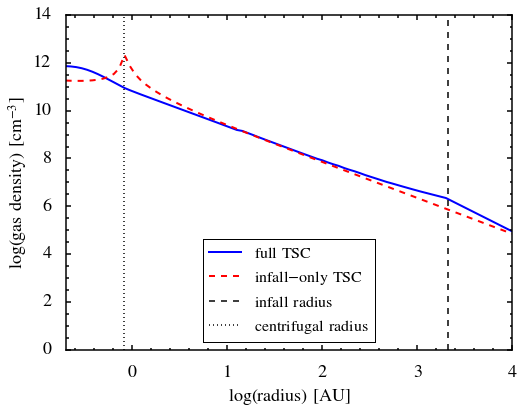

In [69]:
# import hyperion.model as hym
# m = hym.ModelOutput('/Users/yaolun/bhr71/hyperion/cycle7/model46.rtout')
# q = m.get_quantities()
# rho_tsc = q['density'][0].array.T * 100

# create 2d projection
rho_tsc2d = np.sum(rho_tsc**2,axis=2)/np.sum(rho_tsc,axis=2)
rho_ulrich2d = np.sum(rho_ulrich**2,axis=2)/np.sum(rho_ulrich,axis=2)

# make plots

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

plot_grid = [199]
# alpha = np.linspace(0.3,1.0,len(plot_grid))
alpha = [1.0]
for i in plot_grid:
    tsc, = ax.plot(np.log10(rc/AU), np.log10(rho_tsc2d[:,i]/mh), alpha=alpha[plot_grid.index(i)], color='b', linewidth=2)
    ulrich, = ax.plot(np.log10(rc/AU), np.log10(rho_ulrich2d[:,i]/mh), alpha=alpha[plot_grid.index(i)], linestyle='--', color='r', linewidth=2)

rinf = ax.axvline(np.log10(R_inf/AU), linestyle='--', color='k', linewidth=1.5)
cen_r = ax.axvline(np.log10(R_cen/AU), linestyle=':', color='k', linewidth=1.5)

ax.legend([tsc, ulrich, rinf, cen_r], [r'$\rm{full\,TSC}$', r'$\rm{infall-only\,TSC}$', r'$\rm{infall\,radius}$', r'$\rm{centrifugal\,radius}$'],\
          fontsize=16, numpoints=1, loc='lower center')

ax.set_ylim([0, 14])
fig.gca().set_xlim(left=np.log10(0.2))
ax.set_xlabel(r'$\rm{log(radius)\,[AU]}$', fontsize=18)
ax.set_ylabel(r'$\rm{log(gas\,density)\,[cm^{-3}]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

# fix the tick label font
ticks_font = mpl.font_manager.FontProperties(family='STIXGeneral',size=18)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)
    
fig.savefig('/Users/yaolun/bhr71/hyperion/cycle7/model46_tsc_com_gas_density.pdf', format='pdf', dpi=300, bbox_inches='tight')